### **Install libraries**

In [10]:
!pip install pdfplumber pandas numpy nltk textblob matplotlib seaborn wordcloud scikit-learn streamlit

    BlackBoxAuditing (>=0.1.26ggplot)
                     ~~~~~~~~~^


### **Imports and setup**

In [11]:
import pdfplumber
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.filterwarnings("ignore")

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vaish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vaish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vaish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vaish\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### **Read PDF into DataFrame**

In [12]:
pdf_path = "D:/sem7/Natural_Language_processing/Project_assignment/Gabriel_AnnualReport.pdf"  
all_text = ""

with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        if text:
            all_text += text + " "

df = pd.DataFrame({"text": [all_text]})
print("Total characters in PDF:", len(all_text))


Total characters in PDF: 931113


### **Clean Text**

In [13]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)          # remove digits
    text = re.sub(r'[^\w\s]', '', text)      # remove punctuation
    text = re.sub(r'\s+', ' ', text)         # remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 2]
    return ' '.join(words)

df['clean_text'] = df['text'].apply(clean_text)
print(df['clean_text'][0][:500])


across page corporate overview statutory report remembrance management discussion analysis theme introduction director report message executive chairperson corporate governance report letter managing director business responsibility sustainability report enabling india global ascent mobility india automotive roadmap vision asset acquisition step forward engineering sustainable mobility financial statement engineering innovation renewable energy infrastructure legacy engineering tomorrow standalo


### **Sentence-level Sentiment**

In [14]:
sentences = sent_tokenize(df['text'][0])
sentiments = []

for s in sentences:
    blob = TextBlob(s)
    sentiments.append({"sentence": s, "polarity": blob.sentiment.polarity, "subjectivity": blob.sentiment.subjectivity})

df_sent = pd.DataFrame(sentiments)
print("Average polarity:", df_sent['polarity'].mean())
print("Average subjectivity:", df_sent['subjectivity'].mean())


Average polarity: 0.04739106292958676
Average subjectivity: 0.23458532094795534


#### Visualize Sentiment

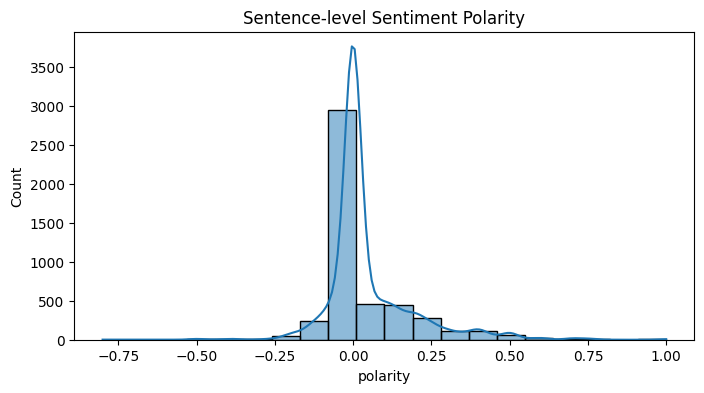

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(df_sent['polarity'], bins=20, kde=True)
plt.title("Sentence-level Sentiment Polarity")
plt.show()


### **Frequent Words & WordCloud**

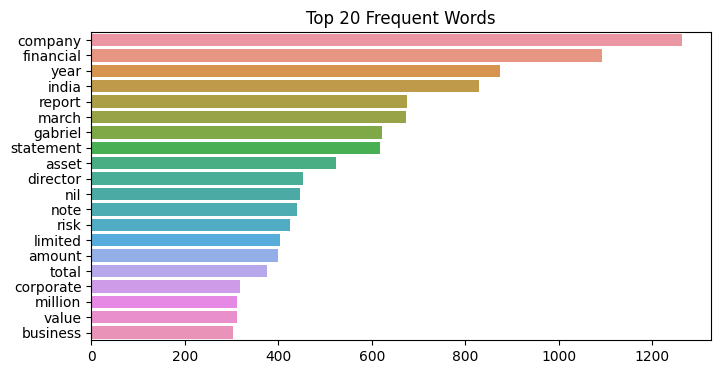

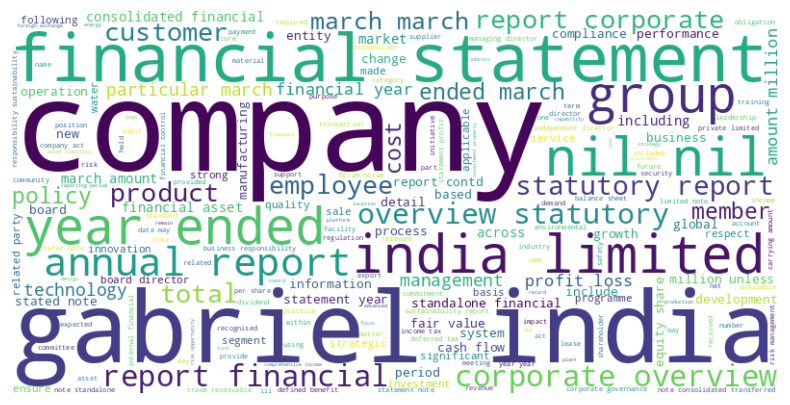

In [16]:
tokens = df['clean_text'][0].split()
freq = pd.Series(tokens).value_counts().head(20)

plt.figure(figsize=(8,4))
sns.barplot(x=freq.values, y=freq.index)
plt.title("Top 20 Frequent Words")
plt.show()

# Wordcloud
wc = WordCloud(width=800, height=400, background_color='white').generate(df['clean_text'][0])
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


### **TF-IDF / Document-Term Matrix**

In [17]:
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf.fit_transform(df['clean_text'])
print("TF-IDF matrix shape:", X.shape)


TF-IDF matrix shape: (1, 1000)


### **Topic Modeling (LDA, 10 topics)**

In [18]:
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

terms = tfidf.get_feature_names_out()

for i, topic in enumerate(lda.components_):
    top_words = [terms[j] for j in topic.argsort()[-10:]]
    print(f"Topic {i+1}:", ", ".join(top_words))


Topic 1: experience, sector, borrowing, evolving, atul, implication, code, location, manner, secretary
Topic 2: experience, sector, borrowing, evolving, atul, implication, code, location, manner, secretary
Topic 3: experience, sector, borrowing, evolving, atul, implication, code, location, manner, secretary
Topic 4: experience, sector, borrowing, evolving, atul, implication, code, location, manner, secretary
Topic 5: experience, sector, borrowing, evolving, atul, implication, code, location, manner, secretary
Topic 6: experience, sector, borrowing, evolving, atul, implication, code, location, manner, secretary
Topic 7: experience, sector, borrowing, evolving, atul, implication, code, location, manner, secretary
Topic 8: director, asset, statement, gabriel, march, report, india, year, financial, company
Topic 9: experience, sector, borrowing, evolving, atul, implication, code, location, manner, secretary
Topic 10: experience, sector, borrowing, evolving, atul, implication, code, locatio

#### Visualize Topics with Bar Charts

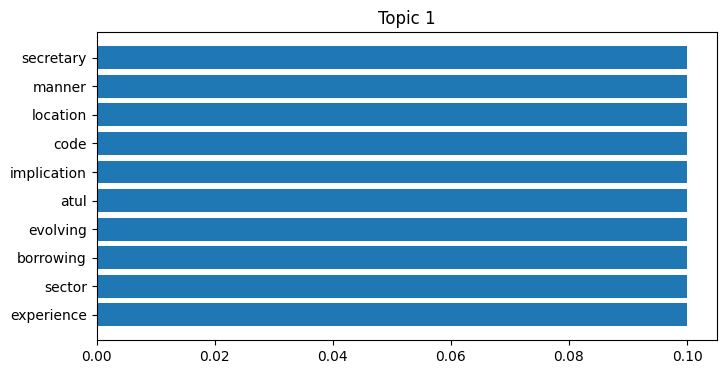

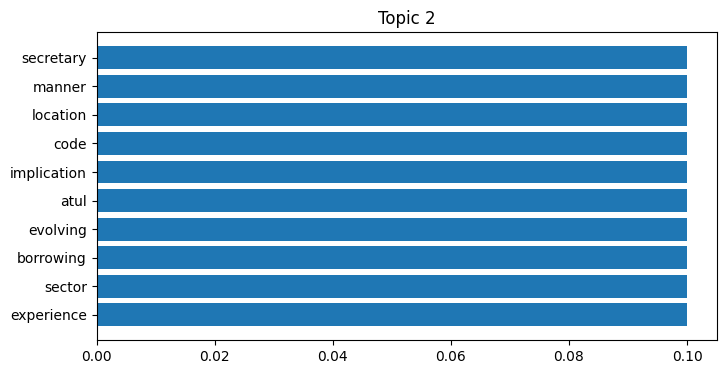

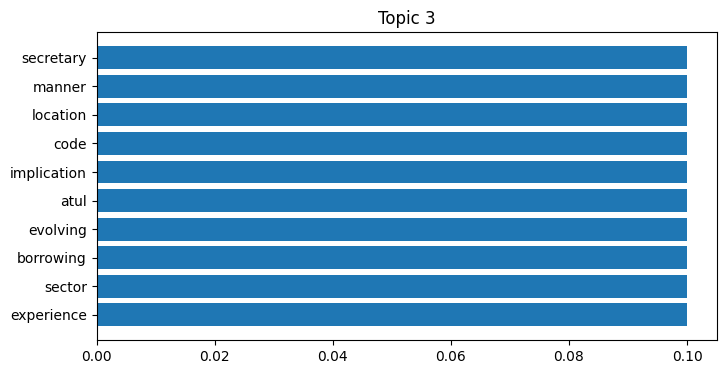

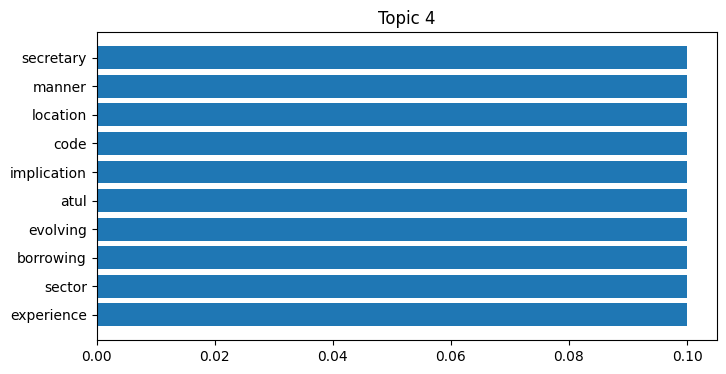

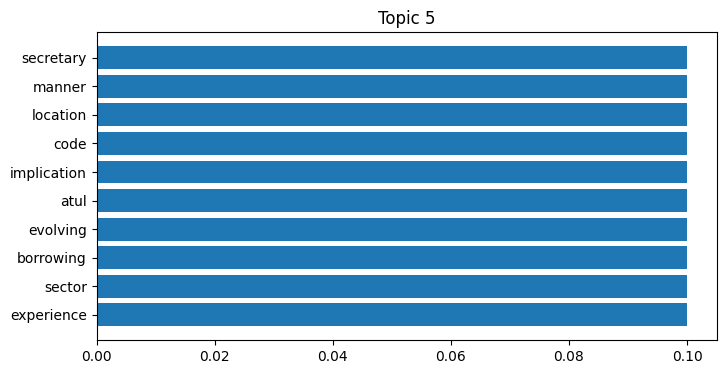

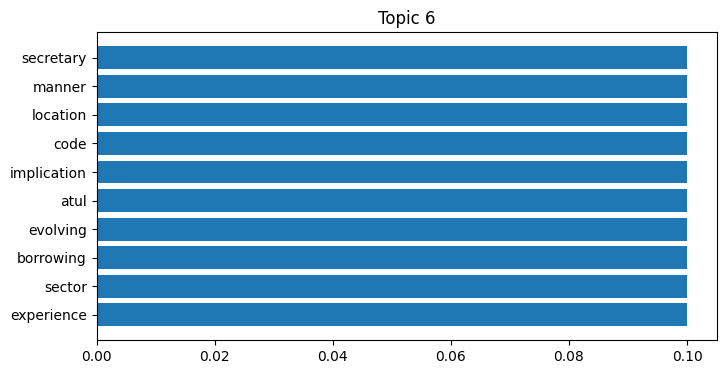

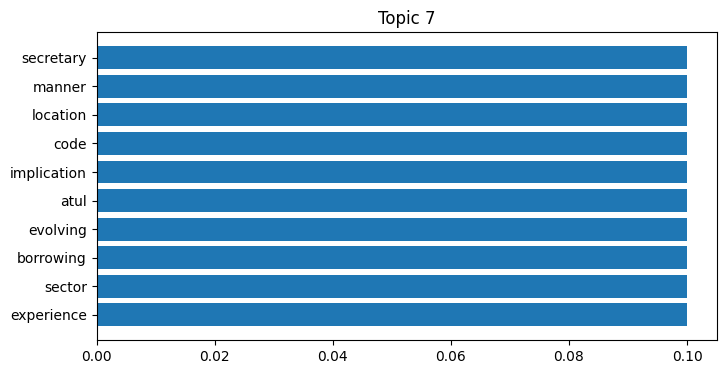

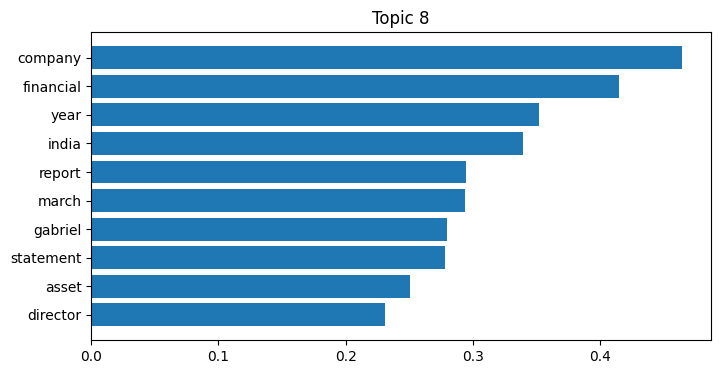

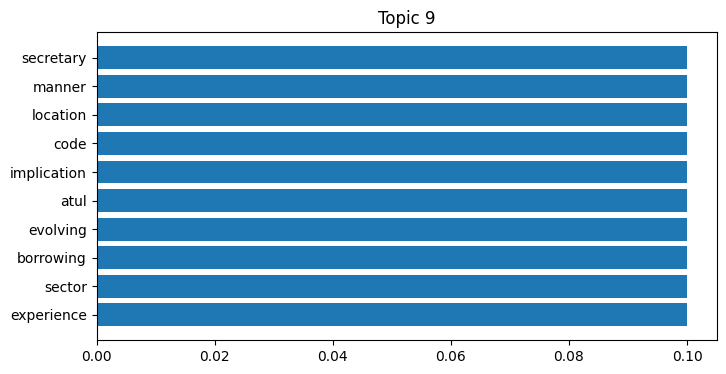

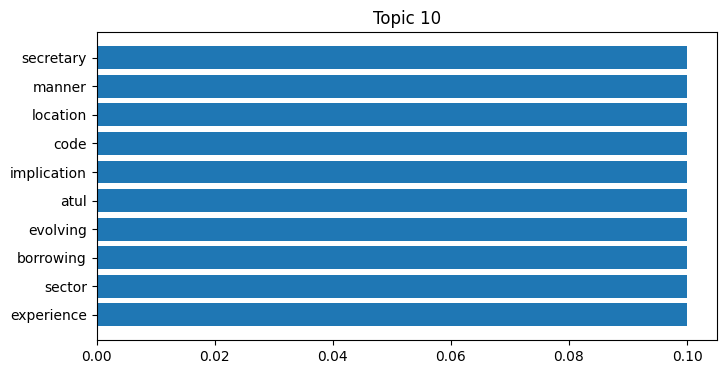

In [19]:
def plot_lda_topics(lda_model, tfidf_vectorizer, n_top_words=10):
    terms = tfidf_vectorizer.get_feature_names_out()
    for i, topic in enumerate(lda_model.components_):
        top_words = [terms[j] for j in topic.argsort()[-n_top_words:]]
        top_weights = topic[topic.argsort()[-n_top_words:]]
        plt.figure(figsize=(8,4))
        plt.barh(top_words, top_weights)
        plt.title(f"Topic {i+1}")
        plt.show()

plot_lda_topics(lda, tfidf)


### **More Insights**

In [20]:
# Top positive & negative sentences
print("Top Positive Sentence:\n", df_sent.loc[df_sent['polarity'].idxmax(), 'sentence'])
print("Top Negative Sentence:\n", df_sent.loc[df_sent['polarity'].idxmin(), 'sentence'])

# Summary statistics
print("Total sentences:", len(df_sent))
print("Average polarity:", df_sent['polarity'].mean())
print("Average subjectivity:", df_sent['subjectivity'].mean())


Top Positive Sentence:
 Gabriel India was recognised as the Best Supplier Inalfa Gabriel Sunroof Systems was awarded
for Environmental Initiative 2024–25 at the HMSI the Best Localisation Award at the HMI
Vendor Meet held on March 19, 2025.
Top Negative Sentence:
 BCP plan outlines the procedures for immediate
The Company has a rationalised vendor base to enhance management level responses to manage the crisis which
purchasing efficiencies.
Total sentences: 4781
Average polarity: 0.04739106292958676
Average subjectivity: 0.23458532094795534
